<h1>Networks of friends<span class="tocSkip"></span></h1>

by Sebastian Wolf

**Network analysis of [Steam](https://store.steampowered.com) friends**

In this notebook, I study the group of heavy gamers, and their connections with other heavy gamers. Specifically, I am interested to see the size distribution of heavy gaming communties, and whether 'hub' users play more than other heavy gamers.

# Setup

## Packages and spark

In [1]:
# Make sure script changes take effect within this session
%load_ext autoreload
%autoreload 2

In [2]:
# import some useful packages for this analysis, start spark session
from setup import *

In [3]:
spark

Open localhost:4040 to monitor the spark UI

## Load csv

### Heavy gamers

We first load the data for heavy gamers from the analytics notebook

In [4]:
# load csv
heavy_gamers = pd.read_csv(os.path.join(path,'heavy_gamers.csv'))
heavy_gamers.head()

Unnamed: 0  Unnamed: 0.1            steamid  playtime_forever_player  \
0         449           449  76561197972186634                   13,962   
1         516           516  76561197972434710                  151,143   
2         808           808  76561197983081747                  188,902   
3         815           815  76561197983325023                   37,880   
4         839           839  76561197984313147                  132,848   

   game_count_player  multiplayer_count_player  spending_player  \
0                  4                         2               35   
1                210                        67            2,548   
2                 34                        25              353   
3                 10                         7               85   
4                 62                        29              785   

   playtime_average_player  multiplayer_fraction_player  \
0                        6                            0   
1                        8                            0   
2                        5                            1   
3                        6                            1   
4                        9                            0   

            primaryclanid      datetimecreated  group_count_player  \
0 103,582,791,429,524,896  2004-12-23 15:45:34                  36   
1 103,582,791,432,727,328  2004-12-26 18:03:28                   1   
2 103,582,791,429,768,128  2006-06-11 19:02:22                  71   
3 103,582,791,429,521,408  2006-06-24 20:48:24                   2   
4 103,582,791,429,521,408  2006-08-16 05:57:08                   1   

               steamid_a  friend_count  playtime_average_friends  \
0 76,561,197,972,186,640            45                         4   
1 76,561,197,972,434,704            21                       nan   
2 76,561,197,983,081,744            35                         0   
3 76,561,197,983,325,024            19                       nan   
4 76,561,197,984,313,152            15                         2   

   playtime_average_friends_max  playtime_forever_friends  \
0                             9                    65,966   
1                           nan                       nan   
2                             0                    78,730   
3                           nan                       nan   
4                             2                    19,771   

   playtime_forever_friends_max  game_count_friends  \
0                       115,189                  20   
1                           nan                 nan   
2                        78,730                  38   
3                           nan                 nan   
4                        19,771                  16   

   multiplayer_count_friends  multiplayer_fraction_friends  spending_friends  
0                         12                             1               208  
1                        nan                           nan               nan  
2                         23                             1               646  
3                        nan                           nan               nan  
4                          8                             0               145

In [5]:
# Take only columns we need
heavy_gamers_select = heavy_gamers.loc[:,['steamid', 'playtime_forever_player', 'playtime_average_player']]
heavy_gamers_select

steamid  playtime_forever_player  playtime_average_player
0      76561197972186634                   13,962                        6
1      76561197972434710                  151,143                        8
2      76561197983081747                  188,902                        5
3      76561197983325023                   37,880                        6
4      76561197984313147                  132,848                        9
...                  ...                      ...                      ...
17532  76561198075782386                   84,283                        6
17533  76561198076771601                   15,817                        8
17534  76561198077114264                  144,439                       11
17535  76561198077882674                   20,151                       11
17536  76561198084817468                   28,140                        6

[17537 rows x 3 columns]

In [6]:
# Make spark df
heavy_gamers_spark = spark.createDataFrame(heavy_gamers_select)

In [7]:
# get list of user ids
heavy_gamers_list = [i.steamid for i in heavy_gamers_spark.select('steamid').distinct().collect()]

### Friends

Load the list of friends

In [8]:
# load raw friends table
spark_handler = spark_df_handler()
spark_handler.load('Friends')
friends = spark_handler.dfraw['Friends']
friends.limit(5).toPandas()

steamid_a          steamid_b             friend_since  \
0  76561198034226262  76561198051094997  2012-10-14 06:47:00 UTC   
1  76561198013746162  76561197989669081  2010-03-19 15:21:50 UTC   
2  76561197960473695  76561197979549848  2009-12-06 15:57:55 UTC   
3  76561198039581539  76561198054240503  2012-03-29 11:41:53 UTC   
4  76561198075201296  76561198097548575  2013-07-23 23:14:36 UTC   

             dateretrieved  
0  2013-07-21 13:31:09 UTC  
1  2013-05-23 11:34:26 UTC  
2  2013-05-06 21:28:53 UTC  
3  2013-08-17 17:19:00 UTC  
4  2013-10-10 13:37:21 UTC

In [9]:
# do some conversion and selection
friends = friends.select('steamid_a', 'steamid_b')
friends = friends.withColumn('steamid_a', F.col('steamid_a').cast('long'))
friends = friends.withColumn('steamid_b', F.col('steamid_b').cast('long'))
friends

DataFrame[steamid_a: bigint, steamid_b: bigint]

In [10]:
# count number of raw data rows
friends.count()

16450558

In [11]:
# Filter for heavy gamers exclusively
friends_filter = friends.where(F.col('steamid_a').isin(heavy_gamers_list))\
                        .where(F.col('steamid_b').isin(heavy_gamers_list))

In [12]:
# Count how many frienships we have left
friends_filter.count()

3120

### Join

Join the list of heavy friends to their playtime data

In [13]:
# Join spark dfs
friends_joined = heavy_gamers_spark.join(friends_filter, heavy_gamers_spark.steamid == friends_filter.steamid_a, how = 'inner')

In [14]:
# collect to Pandas
friends_joined_pd = friends_joined.toPandas()

In [15]:
# Save and read
friends_joined_pd.to_csv(os.path.join(path, 'heavy_gamer_network.csv'), index = False)
friends_joined_pd = pd.read_csv(os.path.join(path, 'heavy_gamer_network.csv'))

In [16]:
# drop some columns
friends_joined_pd = friends_joined_pd.drop('steamid_a', axis = 'columns')

In [17]:
friends_joined_pd

steamid  playtime_forever_player  playtime_average_player  \
0     76561198019634155                  139,824                        7   
1     76561198029281612                  113,913                        6   
2     76561198033368994                  183,953                        8   
3     76561198053397661                   73,180                        6   
4     76561198053397661                   73,180                        6   
...                 ...                      ...                      ...   
3115  76561198076665021                   39,564                        7   
3116  76561198076665021                   39,564                        7   
3117  76561198077051888                   16,499                        7   
3118  76561198077108735                  124,810                        7   
3119  76561198077108735                  124,810                        7   

              steamid_b  
0     76561198026333246  
1     76561198050189372  
2     76561198054408753  
3     76561198046279872  
4     76561198073741416  
...                 ...  
3115  76561198077486051  
3116  76561198068987545  
3117  76561198073465444  
3118  76561198046161210  
3119  76561198039202138  

[3120 rows x 4 columns]

# Network Analysis

## Create graph

In [18]:
import networkx as nx

In [19]:
# Create networkx graph object from our pandas df
%%time
# Create graph
graph = nx.convert_matrix.from_pandas_edgelist(friends_joined_pd, source = 'steamid', target = 'steamid_b', edge_attr = True)

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 22.6 ms


In [20]:
# Get some basic info about the graph
N,K = graph.order(), graph.size() 
avg_deg = float(K)/N
print("Nodes: ", N)
print("Edges: ", K)
print("Average degree: ", round(avg_deg,2))

Nodes:  2363
Edges:  1560
Average degree:  0.66


## Degree distribution
- Most gamers have only 1 friend that is also a heavy gamer
- A few gamers seem to act as hubs

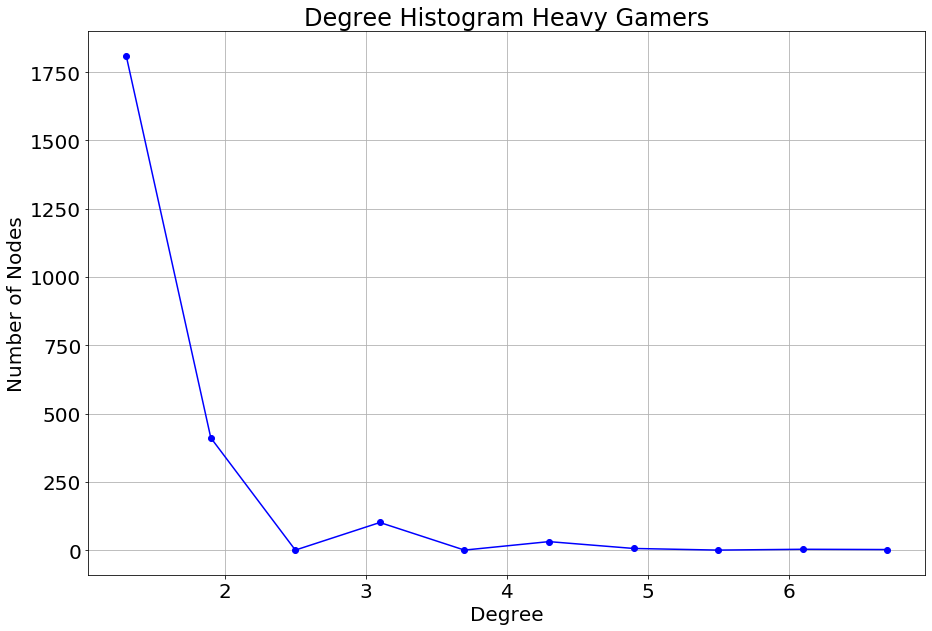

In [21]:
# create a histogram of all nodes' degrees
import collections
degree = sorted([d for n, d in graph.degree()])  # degree sequenc

counts, bin_edges = np.histogram(degree, 10)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.

fig, axes = plt.subplots(nrows=1,ncols=1, figsize = (15, 10))
plt.plot(bin_centres, counts, 'bo-')
plt.title("Degree Histogram Heavy Gamers")
plt.ylabel("Number of Nodes")
plt.xlabel("Degree")
plt.grid(True)

## Static plot
- We can nicely see that there are many small gamer pairs or triplets
- However, there seems to exist a 'super-gamer' network of many heavy gamers

In [22]:
%%time
# Create the layout for our graph
pos = nx.spring_layout(graph, iterations = 50, k = 0.03)

CPU times: user 24.3 s, sys: 0 ns, total: 24.3 s
Wall time: 25.8 s


CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 59.6 ms


Text(0.5, 1.0, 'Heavy gamer network')

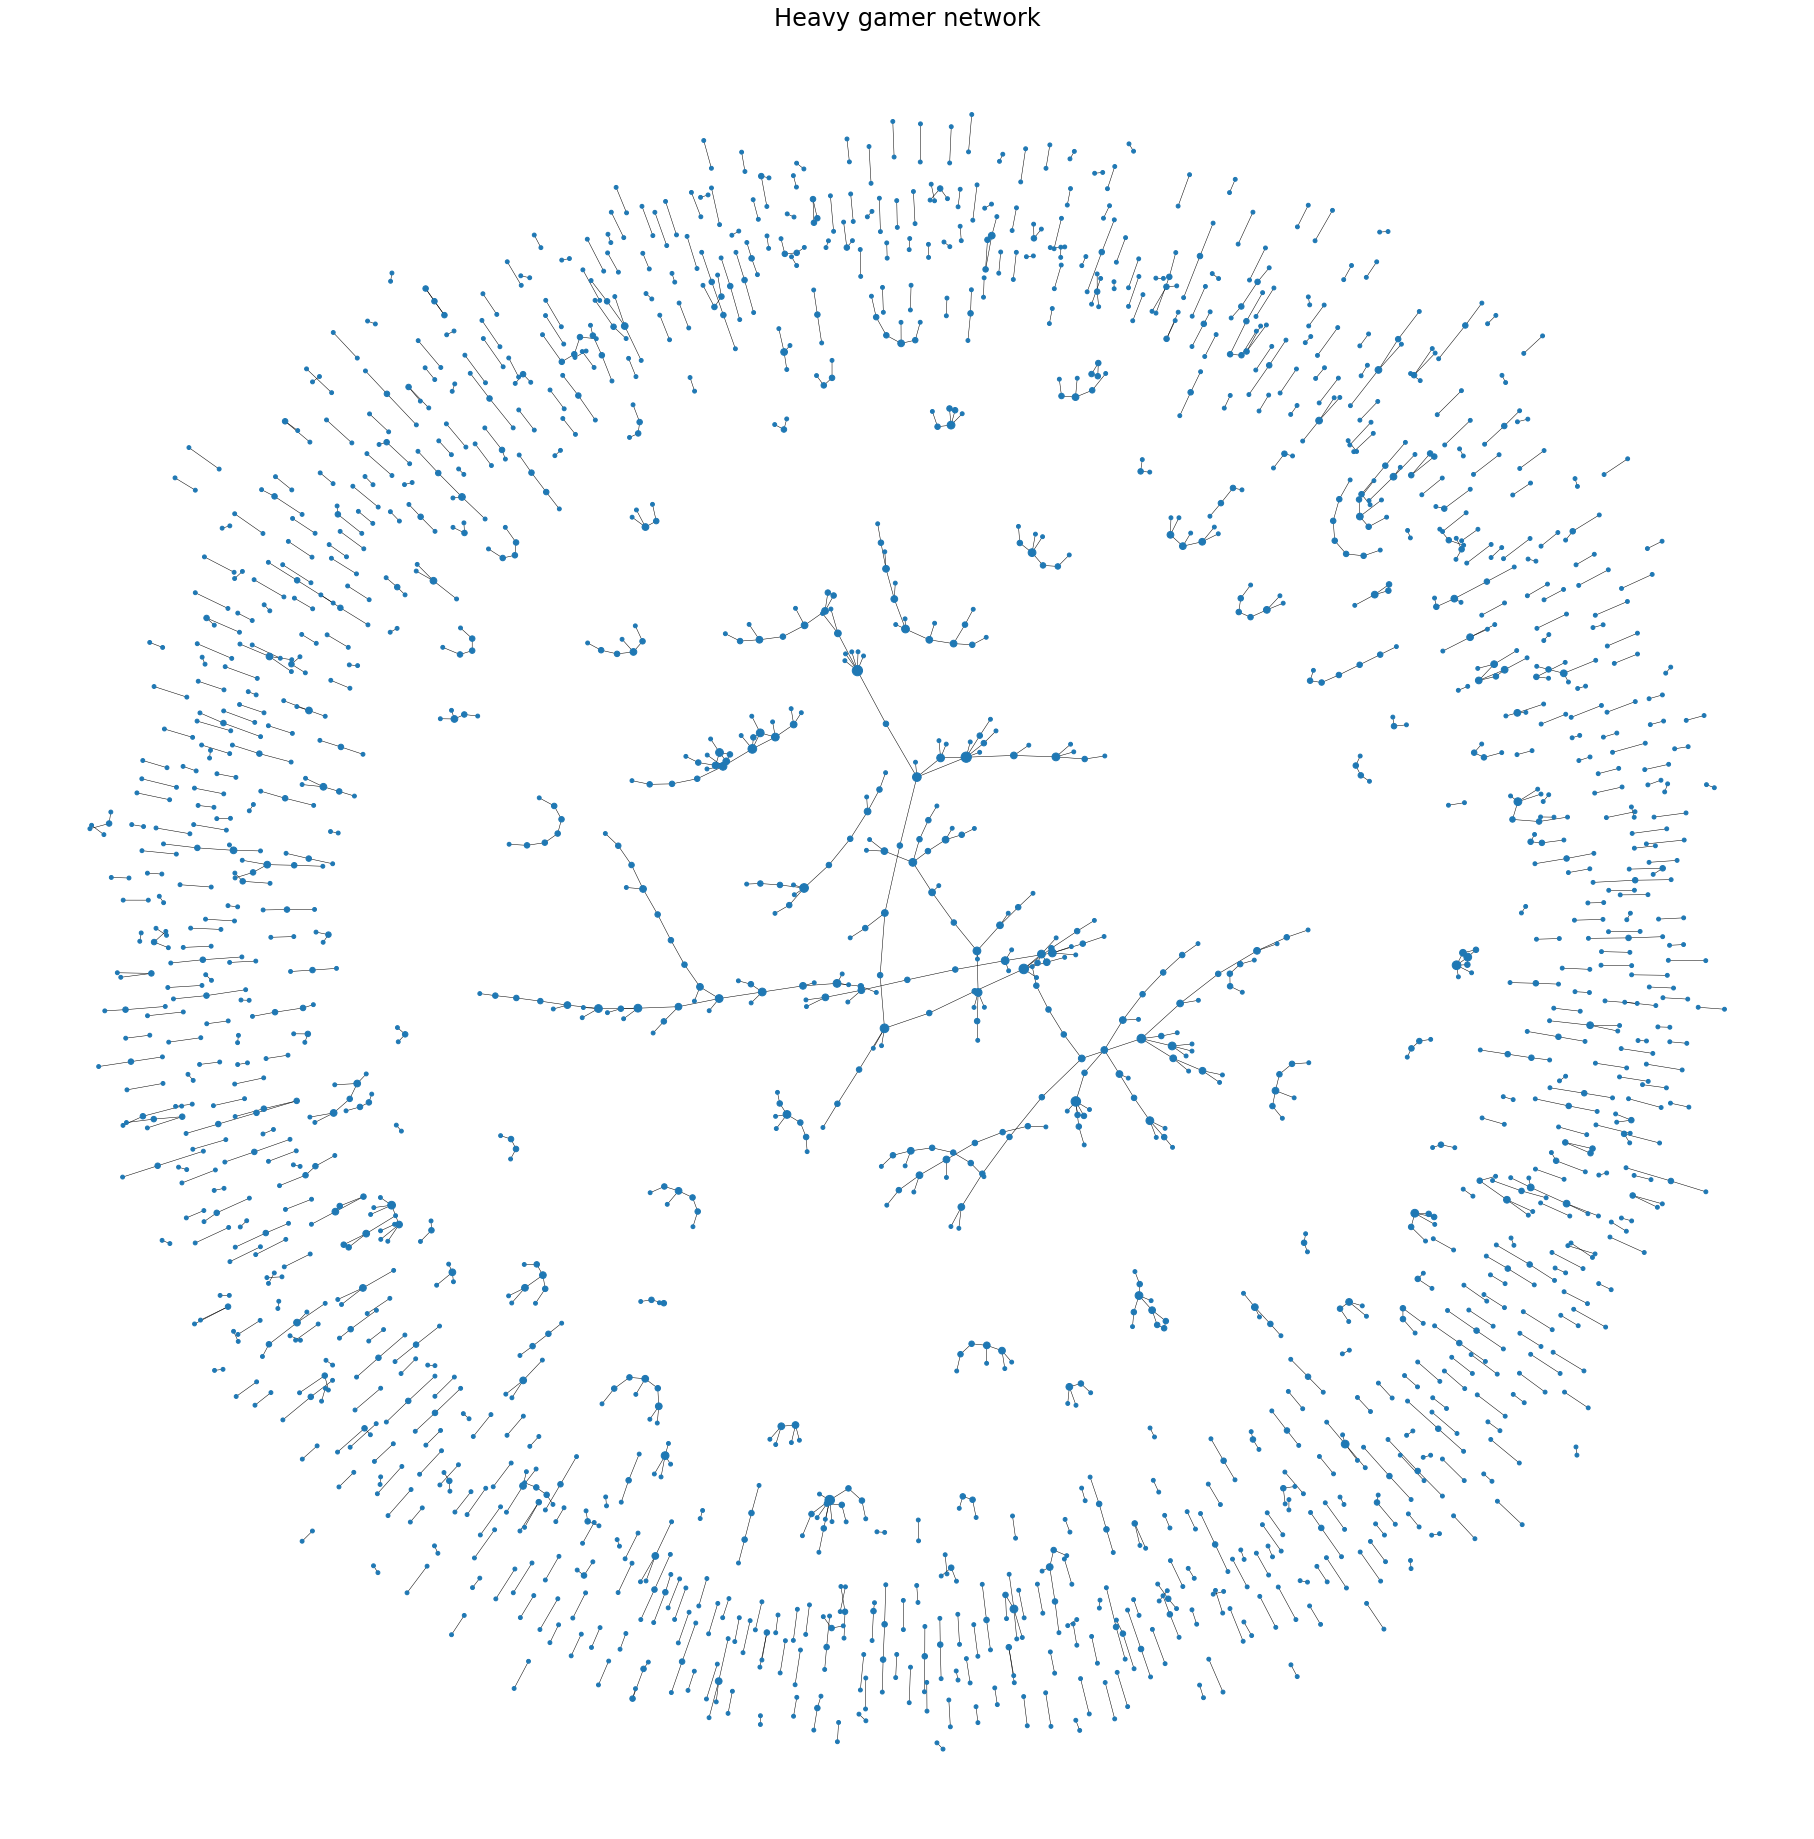

In [23]:
# Draw the graph
%%time
plt.figure(figsize=(25,25))

node_sizes = [v*15 for k, v in graph.degree()]

options = {
    'node_size' : node_sizes, 
    'width': 0.5,
    'alpha' : 1,
    'with_labels': False,
}

nx.draw(graph, 
        pos,
        **options)
plt.title("Heavy gamer network")

## Interactive plot
- The interactive plot allows zooming in to study individual communities

In [24]:
# Make the labels for the interactive graph
labels = []
for k in graph.nodes:
    labels.append('Average Playtime: ' + str(round(friends_joined_pd[friends_joined_pd.steamid == k].playtime_average_player.iloc[0],1)) + \
                 '\n Total Playtime: ' + str(round(friends_joined_pd[friends_joined_pd.steamid == k].playtime_forever_player.iloc[0] / 60,1)))

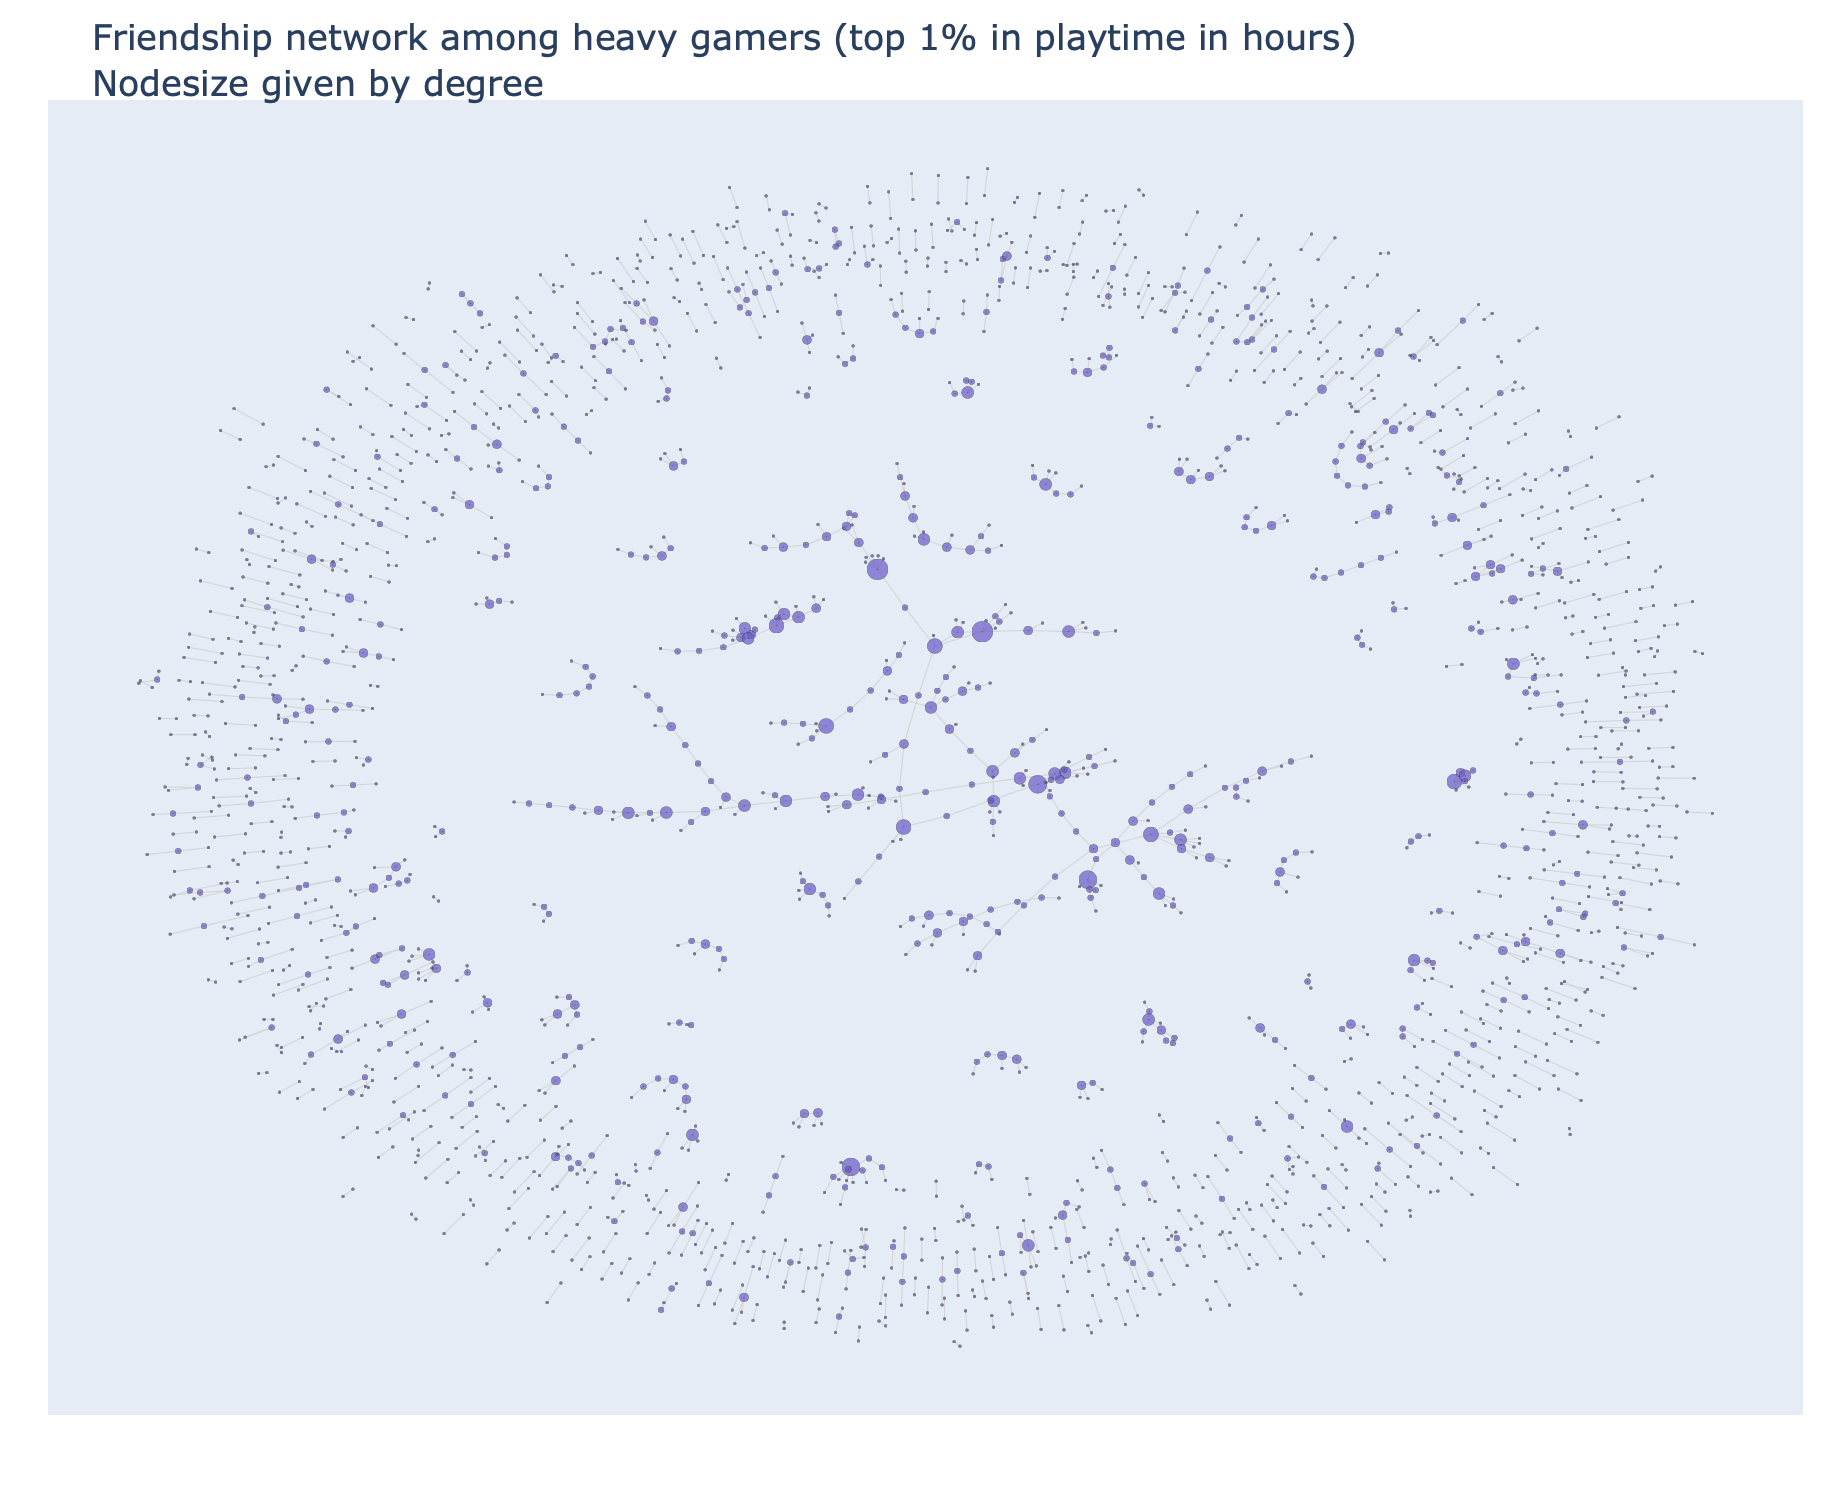

In [25]:
# Make the interactive graph
import plotly.graph_objects as go

Xv=[pos[k][0] for k in graph.nodes]
Yv=[pos[k][1] for k in graph.nodes]
Xed=[]
Yed=[]
for edge in graph.edges:
    Xed+=[pos[edge[0]][0],pos[edge[1]][0], None]
    Yed+=[pos[edge[0]][1],pos[edge[1]][1], None]

trace1=go.Scatter(x=Xed,
               y=Yed,
               mode='lines',
               line=dict(color='rgb(210,210,210)', width=1),
               hoverinfo='none'
               )

node_sizes = [v*3 for k, v in graph.degree()]

trace2=go.Scatter(x=Xv,
               y=Yv,
               mode='markers',
               name='net',
               marker=dict(symbol='circle-dot',
                             size=node_sizes,
                             color='#6959CD',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )

axis=dict(showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

width=800
height=800
layout=go.Layout(title= "Friendship network among heavy gamers (top 1% in playtime in hours) <br> Nodesize given by degree",
    font= dict(size=25),
    showlegend=False,
    autosize=False,
    width=width,
    height=height,
    xaxis=go.layout.XAxis(axis),
    yaxis=go.layout.YAxis(axis),
    margin=go.layout.Margin(
        l=40,
        r=40,
        b=85,
        t=100,
    ),
    hovermode='closest')


data1=[trace1, trace2]
fig1=go.Figure(data=data1, layout=layout)
fig1.update_layout(
    autosize=False,
    width=1500,
    height=1500)
fig1.show()

## Centrality measures and clustering

### Clustering coefficient

In [26]:
# Average clustering coefficient
ccs = nx.clustering(graph) 
avg_clust = sum(ccs.values()) / len(ccs)
avg_clust

0.018725187916893375

### Centrality measures - do we find correlation with playtime?
- We do not find corrleation between a gamer's playtime and her centrality in the network

In [27]:
%%time
# Betweenness centrality
bet_cen = nx.betweenness_centrality(graph)
 # Closeness centrality
clo_cen = nx.closeness_centrality(graph)
 # Eigenvector centrality
eig_cen = nx.eigenvector_centrality_numpy(graph)

CPU times: user 3.97 s, sys: 0 ns, total: 3.97 s
Wall time: 3.88 s


In [28]:
# Get centralities and playtimes in matching lists
bet_cen_list = []
clo_cen_list = []
eig_cen_list = []
playtimes_list = []
for k in graph.nodes:
    playtimes_list.append(friends_joined_pd[friends_joined_pd.steamid == k].playtime_average_player.iloc[0])
    bet_cen_list.append(bet_cen[k])
    clo_cen_list.append(clo_cen[k])
    eig_cen_list.append(eig_cen[k])

In [29]:
# compute correlations
from scipy.stats.stats import pearsonr    
print('Correlation betweeness centrality and playtime: ' + str(round(pearsonr(bet_cen_list,playtimes_list)[0],3)) + ', p-value: ' +  str(round(pearsonr(bet_cen_list,playtimes_list)[1],3)))
print('Correlation closesness centrality and playtime: ' + str(round(pearsonr(clo_cen_list,playtimes_list)[0],3)) + ', p-value: ' +  str(round(pearsonr(clo_cen_list,playtimes_list)[1],3)))
print('Correlation eigenvector centrality and playtime: ' + str(round(pearsonr(eig_cen_list,playtimes_list)[0],3)) + ', p-value: ' +  str(round(pearsonr(eig_cen_list,playtimes_list)[1],3)))

Correlation betweeness centrality and playtime: 0.014, p-value: 0.503
Correlation closesness centrality and playtime: 0.05, p-value: 0.015
Correlation eigenvector centrality and playtime: 0.035, p-value: 0.085


#### Focus on the largest connected component - do we find correlation with playtime?
- We find very weak correlation between playtime and eigenvector centrality for the largest component
- This result can only be taken as an indication, it could just be the result of randomness

In [30]:
# extract the largest connected component
largest_connected_component = max(nx.connected_components(graph), key=len)

In [31]:
# make it a seperate graph
largest_connected_component_graph = graph.subgraph(largest_connected_component)

CPU times: user 50 ms, sys: 0 ns, total: 50 ms
Wall time: 44.9 ms


Text(0.5, 1.0, 'Largest heavy gamer community')

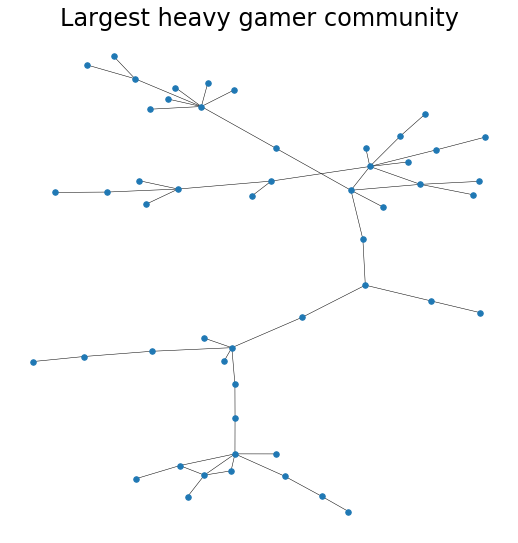

In [32]:
# draw the subgraph
%%time
pos = nx.spring_layout(largest_connected_component_graph, iterations = 100, k = 0.03)

plt.figure(figsize=(7,7))

"""
Using the spring layout : 
- k controls the distance between the nodes and varies between 0 and 1
- iterations is the number of times simulated annealing is run
default k=0.1 and iterations=50
""" 

options = {
    'node_size' : 30,
    'width': 0.5,
    'alpha' : 1,
    'with_labels': False,
}

nx.draw(largest_connected_component_graph, 
        pos,
        **options)
plt.title("Largest heavy gamer community")

Recalculate correlations between centrality measures and playtime for the subgraph:

In [33]:
%%time
# Betweenness centrality
bet_cen = nx.betweenness_centrality(largest_connected_component_graph)
 # Closeness centrality
clo_cen = nx.closeness_centrality(largest_connected_component_graph)
 # Eigenvector centrality
eig_cen = nx.eigenvector_centrality_numpy(largest_connected_component_graph)

CPU times: user 90 ms, sys: 0 ns, total: 90 ms
Wall time: 81.2 ms


In [34]:
# Get centralities and playtimes in matching lists
bet_cen_list = []
clo_cen_list = []
eig_cen_list = []
playtimes_list = []
for k in largest_connected_component_graph.nodes:
    playtimes_list.append(friends_joined_pd[friends_joined_pd.steamid == k].playtime_average_player.iloc[0])
    bet_cen_list.append(bet_cen[k])
    clo_cen_list.append(clo_cen[k])
    eig_cen_list.append(eig_cen[k])

In [35]:
# compute correlations
from scipy.stats.stats import pearsonr    
print('Correlation betweeness centrality and playtime: ' + str(round(pearsonr(bet_cen_list,playtimes_list)[0],3)) + ', p-value: ' +  str(round(pearsonr(bet_cen_list,playtimes_list)[1],3)))
print('Correlation closesness centrality and playtime: ' + str(round(pearsonr(clo_cen_list,playtimes_list)[0],3)) + ', p-value: ' +  str(round(pearsonr(clo_cen_list,playtimes_list)[1],3)))
print('Correlation eigenvector centrality and playtime: ' + str(round(pearsonr(eig_cen_list,playtimes_list)[0],3)) + ', p-value: ' +  str(round(pearsonr(eig_cen_list,playtimes_list)[1],3)))

Correlation betweeness centrality and playtime: -0.062, p-value: 0.664
Correlation closesness centrality and playtime: 0.07, p-value: 0.619
Correlation eigenvector centrality and playtime: 0.222, p-value: 0.114
